# Use a preconditioned convolutional network model

A common and efficient way to do deep learning on small image datasets is to use pre-trained network models.The pre-trained network model is just a network model that has been previously saved after training on a large data set, often with a large image classification task.

If this raw dataset is large enough and universally adequate, then **the level of spatial features learned by trained networks can effectively serve as a universal model for our visual world **and therefore its characteristics prove to be useful for many different computer vision problems , Even though these new questions may involve completely different types from the original ones.

For example, you can train a network on ImageNet, where images are primarily animal and everyday items, and then re-use this well-trained web model to identify the furniture in the image.Compared with many older shallow learning methods, this portability of learning features of different problems is one of the major advantages of deep learning, which makes deep learning very effective for small data image data problems.

## Use VGG16 to pre-train

There are two ways to use pre-trained network models: **feature extraction** and **fine-tuning**.

In [1]:
import platform
import tensorflow
import keras
print("Platform: {}".format(platform.platform()))
print("Tensorflow version: {}".format(tensorflow.__version__))
print("Keras version: {}".format(keras.__version__))

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from IPython.display import Image

Using TensorFlow backend.


Platform: Windows-10-10.0.16299-SP0
Tensorflow version: 1.4.0
Keras version: 2.1.2


# Data set description

Kaggle

data set: Dogs vs. Cats [download](https://www.kaggle.com/c/dogs-vs-cats/data)

![dataset](https://imgur.com/0Il4OZF.png)

The original dataset contains images of 25,000 dogs and cats (12,500 per category) and a size of 543MB (compressed). 

After downloading and extracting, we will create a new data set containing three subsets: a set of **Training sets** containing **1000** samples per class, a **Validation set** of **500** samples per set, and the last one containing **500** for each class **Test set** of a sample.
<br><br><br>
### About the data prepare code is in 1.4-small-datasets-image-augmentation###

In [2]:
import os

# ROOT_DIR = os.getcwd()
original_dataset_dir = "D:/Program/dataset/Dogs_vs_Cats"

def create_directory(datapath, subname):
    child_datapath = os.path.join(datapath, subname)
    if not os.path.exists(child_datapath): 
        os.mkdir(child_datapath)
        
    return child_datapath


# Create a directory to store the data set
base_dir = create_directory(original_dataset_dir, "cats_and_dogs_small")

# Training materials directory
train_dir = create_directory(base_dir, 'train')

# Validation data directory
validation_dir = create_directory(base_dir, 'validation')

# Test data directory
test_dir = create_directory(base_dir, 'test')


# Cat's picture of the training information directory
train_cats_dir = create_directory(train_dir, 'cats')

# Dog pictures of training materials directory
train_dogs_dir = create_directory(train_dir, 'dogs')

# Cat's picture of the authentication data directory
validation_cats_dir = create_directory(validation_dir, 'cats')

# Dog's picture verification information directory
validation_dogs_dir = create_directory(validation_dir, 'dogs')

# Cat's picture of the test data directory
test_cats_dir = create_directory(test_dir, 'cats')

# Dog's picture of the test data directory
test_dogs_dir = create_directory(test_dir, 'dogs')

In [3]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


# Feature Extraction

Feature extraction involves the use of pre-trained network models to extract features from new samples. These features pass a "new" classifier (training from scratch).

As mentioned earlier, the convolutional network architecture for image classification consists of two main parts: they start with a series of convolutional and pooling layers and end with a densely-connected classifier. The first part is called the "convolution base" of the model. In a convolutional network, "feature extraction" will simply include "convolution base" of a previously trained network, re-feed new data therethrough, and train one more according to the output of the "convolution base" New classifier.

![feature extraction](https://s3.amazonaws.com/book.keras.io/img/ch5/swapping_fc_classifier.png)

Why reuse **"convolution base"**? Can we reuse densely-connected classifiers? Generally, it should be avoided. The reason is simply that the features of "convolution base" learning may be more general and therefore more reusable: a convolutional network's feature maps are a mapping of common concepts to images. On the other hand, the features learned by the classifier will be very specific to the set of categories for which the model is trained. They will only contain information about the probability of existence of that class or classes in the whole picture.

In addition, the representations found in densely connected layers no longer contain any information that "space / position" is in the input image: these layers have been freed from the notion of space. For the important and sensitive issue of object location, the functionality of Dense Hierarchy will be largely un-reusable.

Note that the level of generality (and therefore reusability) of representation extracted by a particular convolution layer depends on the depth of the neural layer in the model. **Older layers in the model extract local, highly generic feature maps** (such as visual edges, colors and textures), while higher layers extract more abstract concepts (such as "cat ears" or "dog eyes"). ***So if your new dataset is very different from the dataset your original model was trained on, it's best to use only the first few layers of the model for feature extraction instead of using the entire Convolution Base.***

In our case, it is likely that it would be beneficial to reuse the information contained in the original model's densely populated layer because the ImageNet class collection contains multiple dog and cat classes. However, to cover more generalities, we will not choose to use the original densely-connected layer because the new problem's category set does not overlap with the original model's category set.

Apply the features extracted from our cat and dog images by using the "Convolution Base" of the **VGG16** network trained on ImageNet and then train a cat and dog classifier on top of these features.

In [4]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False, 
                  input_shape=(150, 150, 3)) 

* weights: one of None (random initialization) or 'imagenet' (pre-training on ImageNet).
* include_top: whether to include the 3 fully-connected layers at the top of the network.
* input_shape: optional shape tuple, only to be specified if include_top is False

In [5]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________


There are two ways to proceed:

1. Run "Convolution Base" on our dataset, record its output as a Numpy array onto disk, and then use this as input for a            densely-connected classifier. This solution is fast and easy because it only requires a "convolution base" that runs once for    each input image, and "convolution base" is by far the most expensive part of the pipeline. However, because of the same        reason, this practice does not allow us to use the **data augmentation** approach.<br><br>

2. Extend the model we own (conv_base) by continuing to add the Dense layer to the top of the trained model, and run the entire    data input end-to-end across the input. This approach allows us to use **data augmentation** because every time the input        image is seen by the model, it passes through the "convolution base." However, this technique takes more computation and        training time than the first technique.

### Method 1: Convolution Substrate:Extract features + Concatenate a new dense classification layer: retraining

Record the output of "conv_base" on our data and use these as input for the new model.


In [6]:
%%time
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20 


def extract_features(directory, sample_count): 
    
    # According to the last layer of the VGG16 (convolution base) the turn-out tensor specification
    features = np.zeros(shape=(sample_count, 4, 4, 512)) 
    
    # The number of images to process
    labels = np.zeros(shape=(sample_count)) 
    
    # Produces an "image data generator" instance (the data is in the file directory) and 
    # calls it once, which create specific batch of image data
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),  
        batch_size=batch_size,   
        class_mode='binary')     
    
   
    i = 0
    for inputs_batch, labels_batch in generator:
        # Extract image features through "Convolution Base"
        features_batch = conv_base.predict(inputs_batch)
        # store the feature
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        # store the label
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch 
        i += 1
            
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    
    print('extract_features complete!')
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000) 
validation_features, validation_labels = extract_features(validation_dir, 1000) 
test_features, test_labels = extract_features(test_dir, 1000) 

Found 2000 images belonging to 2 classes.
extract_features complete!
Found 1000 images belonging to 2 classes.
extract_features complete!
Found 1000 images belonging to 2 classes.
extract_features complete!
Wall time: 1min 56s


shape （sample，4，4，512） resize to （sample, 8192）
to connect to the densely-connected Classifier

In [7]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

Define our densely-connected classifier (note the use of dropout for normalization) and train the data and labels we just recorded

In [8]:
from keras import models
from keras.layers import Dense, Dropout
from keras import optimizers

model = models.Sequential()
model.add(Dense(256, activation='relu', input_dim=4*4*512))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid')) # # Because of my information only two categories (cat & dog) 

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.6162 - acc: 0.6600 - val_loss: 0.4412 - val_acc: 0.8360
Epoch 2/30
2000/2000 [==============================] - 1s 678us/step - loss: 0.4360 - acc: 0.7980 - val_loss: 0.3835 - val_acc: 0.8370
Epoch 3/30
2000/2000 [==============================] - 2s 777us/step - loss: 0.3647 - acc: 0.8450 - val_loss: 0.3270 - val_acc: 0.8740
Epoch 4/30
2000/2000 [==============================] - 1s 719us/step - loss: 0.3200 - acc: 0.8630 - val_loss: 0.3032 - val_acc: 0.8900
Epoch 5/30
2000/2000 [==============================] - 1s 676us/step - loss: 0.2890 - acc: 0.8910 - val_loss: 0.2863 - val_acc: 0.8910
Epoch 6/30
2000/2000 [==============================] - 1s 656us/step - loss: 0.2714 - acc: 0.8960 - val_loss: 0.2773 - val_acc: 0.8900
Epoch 7/30
2000/2000 [==============================] - 1s 654us/step - loss: 0.2521 - acc: 0.9070 - val_loss: 0.2666 - val_acc: 0.8970
Ep

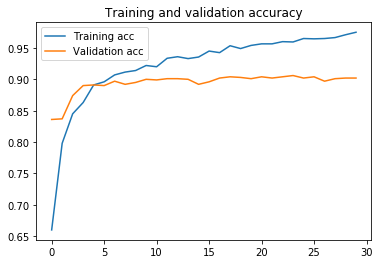

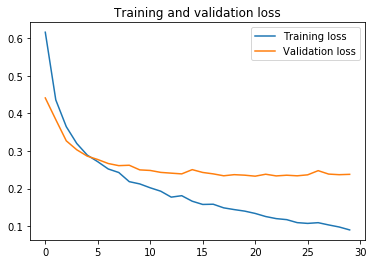

In [9]:
import matplotlib.pyplot as plt

def draw_history(history):

    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, label='Training acc')
    plt.plot(epochs, val_acc, label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
    
draw_history(history)

The validation accuracy rate of about 90%

But, our chart also shows that we were overfitting almost from the very beginning, though we used quite a bit of Dropout.

This is because this technique does not require data expansion (important for preventing overfitting with small image datasets).

## Method 2: (Convolution base: freeze + concatenate new dense classification layer) >> retraining

The second feature extraction technique is much slower and takes more time and computational resources, but we can use data augmentation during training, : Extends the conv_base model and performs end-to-end training.

In [10]:
from keras.layers import Flatten

model = models.Sequential() 
model.add(conv_base)        
model.add(Flatten()) 
model.add(Dense(256, activation='relu'))  
model.add(Dense(1, activation='sigmoid')) 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


## Important: Freeze

Before compiling and training our model, it is important to freeze the "convolution base." 

"Freezing" one or more layers means preventing their weights from being updated during training. 

If we do not do that, the features previously learned on the Convolutional Base will be modified during the training. Since the top Dense layer is randomly initialized, very large weight updates will propagate over the network again, destroying previously learned results.

In [11]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [12]:
# Freeze the convolution base
conv_base.trainable = False

In [13]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


With this setting, only the weights from the two Dense layers we add will be trained. This is a total of four tensors of tensor: two per layer (main weight matrix and deviation vector). Please note that for these changes to take effect, we must first compile the model.

If you modified the weight traitability after compilation, you should recompile the model or the changes will be ignored.

In [14]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# validation data don't need to data augmentation
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 26s 262ms/step - loss: 0.6059 - acc: 0.6705 - val_loss: 0.4771 - val_acc: 0.8000
Epoch 2/30
100/100 [==============================] - 25s 253ms/step - loss: 0.4969 - acc: 0.7685 - val_loss: 0.3787 - val_acc: 0.8550
Epoch 3/30
100/100 [==============================] - 26s 258ms/step - loss: 0.4521 - acc: 0.7895 - val_loss: 0.3846 - val_acc: 0.8260
Epoch 4/30
100/100 [==============================] - 26s 258ms/step - loss: 0.4138 - acc: 0.8265 - val_loss: 0.3164 - val_acc: 0.8720
Epoch 5/30
100/100 [==============================] - 27s 267ms/step - loss: 0.4093 - acc: 0.8065 - val_loss: 0.3127 - val_acc: 0.8770
Epoch 6/30
100/100 [==============================] - 26s 258ms/step - loss: 0.3907 - acc: 0.8165 - val_loss: 0.2890 - val_acc: 0.8840
Epoch 7/30
100/100 [==============================] - 26s 256ms/step - loss: 0.3804 - acc: 0.8385 - val_lo

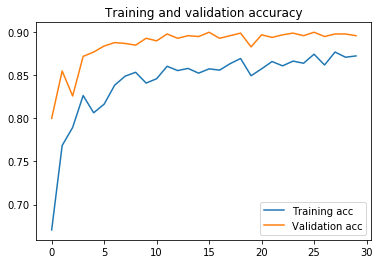

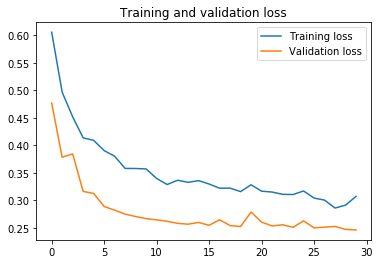

In [15]:
draw_history(history)

In [16]:
model.save('D:/Program/dataset/Dogs_vs_Cats/model/cats_and_dogs_small_2.h5')

# Fine-Tuning

Another widely used model reuse technique, complemented by **feature extraction**, is **fine-tuning**.

Fine-Tuning involves thawing several top layers in the frozen model library for feature extraction and co-training the newly added model parts (in our example fully connected classifiers) and these top layers. This is called "fine-tuning," because it slightly aligns the more abstract representations of models that are being reused to make them more relevant to the current problem to be addressed.

![fine-tuning VGG16](https://s3.amazonaws.com/book.keras.io/img/ch5/vgg16_fine_tuning.png)

Fine-tune the network steps are as follows:
1. Add a custom network to a trained base network.
2. Freeze the base network.
3. Train what you added.
4. Thaw some neural layers in the basal network.
5. Train these layers together with the sections you added.

In the feature extraction, we have completed the first three steps. Let's move on to the fourth step: we will thaw our conv_base, and then freeze some of those particular layers.

In [17]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

We will fine-tune the last three convolution layers, which means that all layers should be frozen until block4_pool, and the layers of block5_conv1, block5_conv2, and block5_conv3 should be trainable.

* The features learned in the earlier neural layers in the Convolutional Substrate represent more generic and more reusable features, while the higher-level features are focused on unique features. It is more useful to fine-tune these neural-layers that focus on unique features, as these features need to be re-trained to solve our new problem. Minimizing the lower layers yields less rewards from existing pre-training models.


* The more parameters we train, the more likely we are overfitting. VGG16's "convolution base" has 15 million parameters, so trying to train on a small dataset is risky.

In [21]:
# Thaw "convolution base"
conv_base.trainable = True 

# All layers should be frozen until block4_pool and blocks5_conv1, block5_conv2, block5_conv3 and block5_pool are thawed     
layers_frozen = ['block5_conv1','block5_conv2', 'block5_conv3', 'block5_pool']
for layer in conv_base.layers:
    if layer.name in layers_frozen:
        layer.trainable = True
    else:
        layer.trainable = False
        
for layer in conv_base.layers:
    print("{}: {}".format(layer.name, layer.trainable))

input_1: False
block1_conv1: False
block1_conv2: False
block1_pool: False
block2_conv1: False
block2_conv2: False
block2_pool: False
block3_conv1: False
block3_conv2: False
block3_conv3: False
block3_pool: False
block4_conv1: False
block4_conv2: False
block4_conv3: False
block4_pool: False
block5_conv1: True
block5_conv2: True
block5_conv3: True
block5_pool: True


Now we can start fine-tuning our network. We will use the RMSprop optimizer with a **very low learning rate**. The reason for the low learning rate is the magnitude of the changes we want to make to the three convolutional representations that we want to fine-tune us. Too much updating can harm these representations.

In [32]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5), # Use a small learn rate
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=70,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/70
100/100 [==============================] - 31s 306ms/step - loss: 0.1038 - acc: 0.9610 - val_loss: 0.2080 - val_acc: 0.9340
Epoch 2/70
100/100 [==============================] - 30s 296ms/step - loss: 0.0827 - acc: 0.9690 - val_loss: 0.2042 - val_acc: 0.9360
Epoch 3/70
100/100 [==============================] - 30s 297ms/step - loss: 0.0829 - acc: 0.9675 - val_loss: 0.2231 - val_acc: 0.9280
Epoch 4/70
100/100 [==============================] - 30s 297ms/step - loss: 0.0877 - acc: 0.9660 - val_loss: 0.1964 - val_acc: 0.9330
Epoch 5/70
100/100 [==============================] - 30s 297ms/step - loss: 0.0859 - acc: 0.9700 - val_loss: 0.2125 - val_acc: 0.9340
Epoch 6/70
100/100 [==============================] - 30s 297ms/step - loss: 0.0693 - acc: 0.9730 - val_loss: 0.1981 - val_acc: 0.9330
Epoch 7/70
100/100 [==============================] - 30s 296ms/step - loss: 0.0755 - acc: 0.9755 - val_loss: 0.1934 - val_acc: 0.9330
Epoch 8/70
100/100 [==============================] - 3

100/100 [==============================] - 30s 296ms/step - loss: 0.0247 - acc: 0.9910 - val_loss: 0.3104 - val_acc: 0.9290
Epoch 62/70
100/100 [==============================] - 30s 296ms/step - loss: 0.0304 - acc: 0.9910 - val_loss: 0.3049 - val_acc: 0.9230
Epoch 63/70
100/100 [==============================] - 29s 295ms/step - loss: 0.0185 - acc: 0.9930 - val_loss: 0.3077 - val_acc: 0.9340
Epoch 64/70
100/100 [==============================] - 30s 296ms/step - loss: 0.0289 - acc: 0.9880 - val_loss: 0.2903 - val_acc: 0.9330
Epoch 65/70
100/100 [==============================] - 29s 295ms/step - loss: 0.0244 - acc: 0.9895 - val_loss: 0.2903 - val_acc: 0.9350
Epoch 66/70
100/100 [==============================] - 30s 295ms/step - loss: 0.0267 - acc: 0.9915 - val_loss: 0.2821 - val_acc: 0.9360
Epoch 67/70
100/100 [==============================] - 30s 296ms/step - loss: 0.0249 - acc: 0.9925 - val_loss: 0.3369 - val_acc: 0.9330
Epoch 68/70
100/100 [==============================] - 30s 2

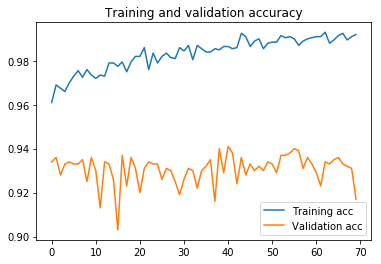

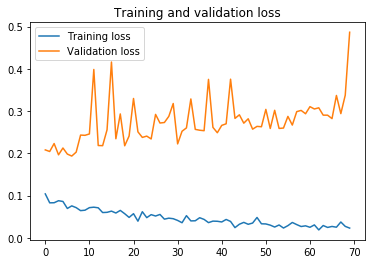

In [33]:
draw_history(history)

These curves look very noisy. To make them more readable, we can smooth them by replacing every loss and accuracy with exponential moving averages of these quantities. Here's a trivial utility function to do this:

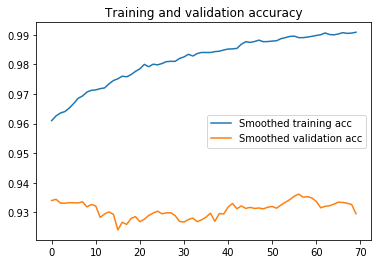

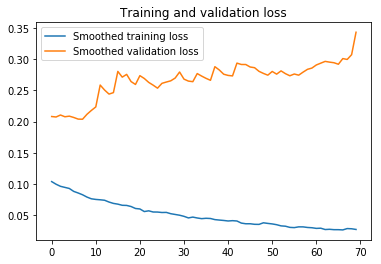

In [34]:
def smooth_curve(points, factor=0.8):
    
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

def draw_smooth_pic(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, smooth_curve(acc), label='Smoothed training acc')
    plt.plot(epochs, smooth_curve(val_acc), label='Smoothed validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, smooth_curve(loss), label='Smoothed training loss')
    plt.plot(epochs,smooth_curve(val_loss), label='Smoothed validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
    
draw_smooth_pic(history)

Note that the loss curve does not show any real improvement (in fact, it is deteriorating). You may wonder, how could accuracy improve if the loss isn't decreasing? The answer is simple: what we display is an average of pointwise loss values, but what actually matters for accuracy is the distribution of the loss values, not their average, since accuracy is the result of a binary thresholding of the class probability predicted by the model. The model may still be improving even if this isn't reflected in the average loss.

We can now finally evaluate this model on the test data:

In [35]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.914999991655


However, using modern deep learning techniques, we managed to reach this result using only a very small fraction of the training data available (about 10%). There is a huge difference between being able to train on 20,000 samples compared to 2,000 samples!

# Summary

* Convnets are the best type of machine learning models for computer vision tasks. It is possible to train one from scratch even on a very small dataset, with decent results.


* On a small dataset, overfitting will be the main issue. Data augmentation is a powerful way to fight overfitting when working with image data.


* It is easy to reuse an existing convnet on a new dataset, via feature extraction. This is a very valuable technique for working with small image datasets.


* As a complement to feature extraction, one may use fine-tuning, which adapts to a new problem some of the representations previously learned by an existing model. This pushes performance a bit further.


Reference:
[fchollet: deep-learning-with-python-notebooks](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.3-using-a-pretrained-convnet.ipynb)